# **Topology Optimization of a Membrane and Report Generation with $\LaTeX$**

In [ ]:
import sympy as sy
from sympy import symbols, Function, diff, Matrix, MatMul, \
    integrate, Symbol, sin, cos, pi, simplify
import pylatex as pltx
from pylatex import Section, Subsection, Command, NoEscape, Package, NewPage
from sigmaepsilon.solid.fourier.latex import expr_to_ltx, expr_to_ltx_breqn
from sigmaepsilon.solid.fourier.symtools import inv_sym_3x3

In [ ]:
geometry_options = {
        "tmargin" : "1.5cm",
        "lmargin" : "1.5cm",
        "rmargin" : "1.5cm"
    }

doc = pltx.Document(geometry_options=geometry_options)

r"""
Tools related to displaying math. It's a bit like the numpy of latex, must
have stuff.
"""
doc.packages.append(Package('amsmath'))

r"""
Sympy uses the 'operatorname' command frequently to print symbols.
"""
doc.packages.append(Package('amsopn'))

r"""
To automatically break long equations into multiple lines.
"""
doc.packages.append(Package('breqn'))

r"""
mathtools provides us with the \coloneqq command, for defining equality
symbol ':='
"""
doc.packages.append(Package('mathtools'))

r"""
Misc
"""
doc.packages.append(Package('enumitem'))  # to customize enumerations
doc.packages.append(Package('xcolor'))  # colors
doc.packages.append(Package('lmodern'))  # high quality fonts

title = "Topology Optimization with the Optimality Criteria Method."
doc.preamble.append(Command('title', title))
doc.preamble.append(Command('author', 'Bence Balogh'))
doc.preamble.append(Command('date', NoEscape(r'\today')))
doc.append(NoEscape(r'\maketitle'))
doc.append(NoEscape(r'\tableofcontents'))
doc.append(NewPage())

sections = {}

In [ ]:
sections['Input'] = doc.create(Section('Input'))

with sections['Input']:
# displacement field
    with doc.create(Subsection('Geometry')):
        doc.append(NoEscape(
            r"""
            \noindent
            The Mindlin-Reissner kinematical model poses the following
            assumptions on the displacement field:
            """))
        doc.append(NoEscape(
            r"""
            \begin{enumerate}[label*=\protect\fbox{MR\arabic{enumi}},
            itemindent=5em]
            \item   normals to the midsurface remain normal
            \item   the plate thickness does not change during deformation
            \item   normal stress through the thickness is ignored
            \end{enumerate}
            """))

In [ ]:
doc.generate_pdf('e:\\tesseract_oc_sym', clean_tex=False, compiler='pdfLaTeX')

## **Step 1 : Define a Mesh**

In [16]:
from sigmaepsilon.mesh.grid import gridQ9
import numpy as np

size = Lx, Ly = (10, 15)
shape = nx, ny = (40, 60)

gridparams = {
    'size' : size,
    'shape' : shape,
    'origo' : (0, 0),
    'start' : 0
    }

coords_, topo = gridQ9(**gridparams)
coords = np.zeros((coords_.shape[0], 3))
coords[:, :2] = coords_[:, :]

## **Step 2 : Define a Material**

In [17]:
E = 12000
nu = 0.2
t = 0.25
A = np.array([[1, nu, 0], [nu, 1, 0], [0., 0, (1-nu)/2]]) * (t * E /(1-nu**2))

## **Step 3 : Set Boundary Conditions**

In [18]:
from sigmaepsilon.mesh.space.utils import index_of_closest_point
# fix points at x==0
#cond = (coordsQ4[:, 0] <= 0.001) & (coordsQ4[:, 1] >= (Ly/2))
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True
#fixity[:, 2:] = True

# unit vertical load on points at (Lx, Ly)
Fz = -100.0
loads = np.zeros((coords.shape[0], 6))
loadindex = index_of_closest_point(coords, np.array([2*Lx/3, Ly/2, 0]))
loads[loadindex, 1] = Fz

## **Step 4 : Assembly and Solution**

In [19]:
from sigmaepsilon.mesh.space import StandardFrame
from sigmaepsilon.solid.fem.mesh import FemMesh
from sigmaepsilon.solid.fem.structure import Structure
from sigmaepsilon.solid.fem.cells import Q9M as Q9
from sigmaepsilon.solid import PointData

GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
cd = Q9(topo=topo, frame=GlobalFrame)
meshQ4 = FemMesh(pd, cd, model=A, frame=GlobalFrame)
structure = Structure(mesh=meshQ4)

structure.linsolve(summary=True)
dofsol = structure.nodal_dof_solution()
structure.mesh.pointdata['x'] = coords + dofsol[:, :3]

## **Step 5 : Triangulate and Plot**

In [ ]:
%matplotlib inline

In [20]:
from sigmaepsilon.mesh.topo.tr import Q4_to_T3
from sigmaepsilon.mesh.tri.trimesh import triangulate
from sigmaepsilon.mesh.tri.triplot import triplot
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
plt.style.use('dark_background')

points, triangles = Q4_to_T3(structure.mesh.coords(), topo)
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]

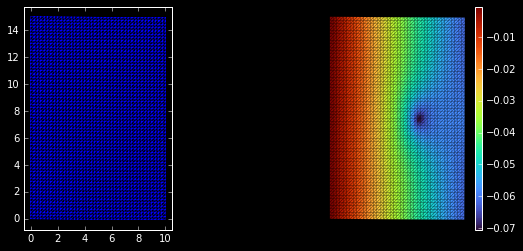

In [21]:
fig = plt.figure(figsize=(10, 4))  # in inches
fig.patch.set_facecolor('black')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
triplot(triobj, ax=ax1, fig=fig)
triplot(triobj, ax=ax2, fig=fig, data=dofsol[:, 1], cmap='turbo', axis='off')

## **Step 6 : Optimize**

In [22]:
%matplotlib qt
plt.style.use('classic')

In [23]:
OC_params = {
    'p_start' : 1.0,  # SIMP penalty factor
    'p_stop' : 3.0,
    'p_inc' : 0.1,
    'p_step' : 5,
    'q' : 0.5,  # smoothing factor
    'vfrac' : 0.5,  # fraction of target volume over initial volume
    'dtol' : 0.1,  #  to control maximum change in the variables
    'r_min' : 2 * max(Lx/nx, Ly/ny),  # for the density filter
    'miniter' : 30,
    'maxiter' : 100
    }

In [24]:
from sigmaepsilon.math import histogram
from matplotlib import gridspec
import matplotlib as mpl
from IPython.display import display, clear_output

fig = plt.figure(figsize=(10, 4))  # in inches
#fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(2, 3, width_ratios=[6, 2, 4])

uz = structure.mesh.pointdata.dofsol[loadindex, 1].min()
nCell = structure.mesh.number_of_cells()
history = {'comp' : [], 'vol' : [], 'x' : []}
history['comp'].append(2*uz*Fz) 
history['x'].append(np.random.rand(nCell))
history['vol'].append(Lx*Ly)

nbins = 10
hist, bin_centers = histogram(history['x'][-1], nbins)
hist = hist.astype(float)
hist /= hist.max()
ax1 = fig.add_subplot(gs[:, 1])
ax1.set_facecolor('white')
bars = ax1.barh(bin_centers, hist, 0.5/nbins)
ax1.set_xlim(0, 1)
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 2])
ax2.axhline(y=history['comp'][-1], color="r", linestyle="--", lw=0.5)
#ax2.set_ylim(0, history['comp'][-1]*1.2)

ax3 = fig.add_subplot(gs[1, 2])
ax3.set_ylim(0, history['vol'][-1])
ax3.axhline(y=history['vol'][-1]*OC_params['vfrac'], 
            color="r", linestyle="--", lw=0.5)

cmap = plt.cm.winter  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)
#cmaplist[-1] = (1., 0., 0., 1.0)
#cmaplist.reverse()
cmaplist[0] = (1., 1., 1., 1.0)
cmaplist[-1] = (1., 0., 0., 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 10, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax4 = fig.add_subplot(gs[:, 0])
points, triangles, edata = \
    Q4_to_T3(coords, topo, data=history['x'][-1])
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]
trifield = triplot(triobj, ax=ax4, data=edata, axis='on', 
                   lw=0.0, fig=fig, cmap=cmap)[0]

def callback_qt(i, comp, vol, dens):
    history['comp'].append(comp)
    history['vol'].append(vol)
    history['x'].append(dens)
    fig.canvas.manager.window.raise_()
    hist, _ = histogram(dens, nbins)
    hist = hist.astype(float)
    hist /= hist.max()
    for bar, h in zip(bars, hist):
        bar.set_width(h)
    ax2.plot(i, comp, marker='o', c='b', markersize='1')
    ax3.plot(i, vol, marker='*', c='g', markersize='1')
    ax2.set_xlim(0, i+1)
    ax3.set_xlim(0, i+1) 
    *_, edata = Q4_to_T3(coords, topo, data=dens)
    trifield.set_array(edata)
    fig.canvas.draw()
    fig.canvas.flush_events()
    
def callback_inline(i, comp, vol, dens):
    history['comp'].append(comp)
    history['vol'].append(vol)
    history['x'].append(dens)
    hist, _ = histogram(dens, nbins)
    hist = hist.astype(float)
    hist /= hist.max()
    
    ax1.cla()
    ax1.barh(bin_centers, hist, 0.5/nbins)
    ax2.plot(i, comp, marker='o', c='b', markersize='1')
    ax3.plot(i, vol, marker='*', c='g', markersize='1')
    ax4.cla()
    *_, edata = Q4_to_T3(coords, topo, data=dens)
    triplot(triobj, ax=ax4, data=edata, axis='off', lw=0.0, 
            fig=fig, cmap=cmap)[0]
    
    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)
       

In [25]:
structure.summary['linsolve', 'proc', 'time']

0.4389994144439697

In [26]:
from sigmaepsilon.topopt.oc.SIMP_OC_FEM import OC_SIMP_COMP as OC
neighbours = structure.mesh.k_nearest_cell_neighbours(7)

In [27]:
# iteration parameters
OC_params = {
    'p_start' : 1.0,  # SIMP penalty factor
    'p_stop' : 2.5,
    'p_inc' : 0.05,
    'p_step' : 10,
    'q' : 0.5,  # smoothing factor
    'vfrac' : 0.15,  # fraction of target volume over initial volume
    'dtol' : 0.1,  #  to control maximum change in the variables
    'r_max' : 3 * max(Lx/nx, Ly/ny),  # for the density filter
    'miniter' : 30,
    'maxiter' : 1e12,
    'neighbours' : neighbours
    }
optimizer = OC(structure, summary=True, **OC_params)
next(optimizer)
ax2.set_xlim(0, len(history['comp']))
ax3.set_xlim(0, len(history['comp']))

(0.0, 1.0)

In [29]:
for i in range(100):
    r = next(optimizer)
    callback_qt(r.n, r.obj, r.vol, r.x)
    ax2.set_xlim(0, len(history['comp']))
    ax3.set_xlim(0, len(history['comp']))